#Ecuación Korteweg-de-Vries(KdV)


La ecuación KdV es una ecuación diferencial en derivadas parciales que sirve como modelo de, entre otras cosas, aguas poco profundas. Fue por primera vez introducida por Boussinesq en 1877 como una nota y redescubierta por Diederik Korteweg y Gustav de Vries en 1895. Esta está dada por la expresión,

$$ \partial_t u + u u_x + \beta \, u_{xxx} = 0 $$



$\bf a)$ Pruebe analíticamente la conservación del momento $P = \int u dx$ y  de la energía $E = \int u^2 dx$.

$\bf b)$ Notando que el estado estacionario es con $u$ constante, calcule la relación de dispersión de ondas linealizando. ¿Qué tipo de ondas son las que encuentra?  


$\bf c)$ Busque la solución de ondas viajeras $u(x-vt) = u (y)$. Para eso, primero note que $u_t = -v u_t$. Escriba el sistema como una ecuación de segundo orden integrando (Note que la presencia de una simetría $v \rightarrow v + w$ antes de integrar permite anular la constante de integración), realice una analogía con una ecuación del movimiento como las que conoce de mecánica newtoniana ($\ddot{x} = - \frac{dV}{dt}$, interprete el tiempo como $x$ y el espacio como $u$) e interprete (grafique el potencial para hacerlo). Discuta la existencia de un único soliton y de un trén de solitones.

$\bf d)$ Escriba un integrador con método pseudoespectral para la ecuación KdV usando Runge-Kutta de orden 2 midpoint para el paso temporal. Hágalo en un recinto de tamaño $2  \ pi$ con condiciones de contorno periódicas y $N = 128$ puntos de grilla. Note que el término $\beta u_{xxx}$, en caso ser dominante exige $dt < \frac{\Delta x^3}{\beta}$. (puede usar un N mayor cuidando el dt para que se cumpla la condición de estabilidad)

$\bf e)$ Sabiendo que la expresión de un solitón está dada por:

$$ u(x,t) = 3 \, v \, \text{cosh}^{-2} \left[ \sqrt{\frac{v}{4 \beta}} (x  - v t) \right]$$

coloque un solitón como condición inicial, calcule su velocidad en función del tiempo y compare con lo que espera. Escriba una condición de dos solitones, uno rápido y uno lento. ¿Se afectan el uno al otro?

$\bf f)$ Del método de scattering inverso se encuentra que usando la transformación

$$ u  = - 6 \beta \left( \lambda + \frac{\psi_{xx}}{\psi}\right)$$

entonces $u$ será una solución de KdV si $\psi$ es solución de la ecuación de Schrödinger con un potencial $V = \frac{-u}{6 \beta}$. Dado el potencial, los lugares donde hayan pozos representan la existencia de estados ligados y resultarán en la emisión de solitones.

Elija una condición inicial, grafique el potencial y vea cómo se emiten solitones desde la zona esperada. Chequee las cantidades conservadas del comienzo.


(Sugerencia: Use $\beta = 0.022$ y $dt = 5e-5$ e integre por tiempo muy largos )

In [ ]:
!pip install findiff
!apt-get install -y ffmpeg
import numpy as np
from typing import Callable
from findiff import FinDiff
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
import scipy
from math import floor
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
from tqdm.auto import trange, tqdm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


$\bf a)$ Comenzamos mostrando la conservación de momento. Reexpresamos la ecuación de KdV como

$$ \partial_t u + \partial_x \left( \frac{u^2}{2} + \beta u_{xx}  \right) = 0  $$

donde utilizamos que $\displaystyle uu_x = \partial_x \left(\frac{u^2}{2} \right)$ y $ u_{xxx} = \partial_x (u_xx) $. Entonces, reordenamos e integramos en el espacio

$$ \boxed{\partial_t \int\limits_0^L u \, dx = - \partial_x \int\limits_0^L \left(\frac{u^2}{2} - \beta u_{xx}  \right) \, dx = \left. \left( \frac{u^2}{2} - \beta u_{xx} \right) \right|^L_0 = 0} $$

donde la nulidad de esta expresión se cumple para condiciones de contorno adecuadas.

Ahora, observemos la conservación de la energía. Tomamos por un momento que $\beta = 0$ y multiplicamos por $u$. Así, la ecuación de KdV resulta

$$ u\partial_t u + u^2 \partial_x u = 0  $$

Entonces, reexpresamos

$$  \partial_t \left(\frac{u^2}{2} \right) + u \partial_x \left(\frac{u^2}{2} \right) = 0 $$

De aquí, reconocemos la aparición de la derivada total. Por lo tanto, podemos expresar:

$$ d_t \left(\frac{u^2}{2} \right) = 0  $$

con lo cual, la ley de conservación local resulta

$$ \boxed{\frac{dE}{dt} = -\beta u u_{xxx}} $$

Con esto, podemos mostrar que la energía se conserva globalmente; integramos a ambos lados la ley de conservación local, con lo cual resulta

$$ \int\limits_0^L \frac{d}{dt} \left(\frac{u^2}{2} \right) \, dx = -\int\limits \beta u u_{xxx} \, dx  $$

Entonces, para el término izquierdo de esta expresión tenemos:

$$ \int\limits_0^L \frac{d}{dt} \left(\frac{u^2}{2} \right) \, dx = \int\limits_0^L \left[\partial_t \left(\frac{u^2}{2} \right) + u \partial_x \left( \frac{u^2}{2} \right) \right] \, dx = \int\limits_0^L \partial_t \left( \frac{u^2}{2} \right) \, dx + \int\limits_0^L u \partial_x \left( \frac{u^2}{2} \right) \, dx$$

Ahora, hago integración por partes:

$$ \int\limits_0^L \frac{d}{dt} \left( \frac{u^2}{2} \right) \, dx = \partial_t \int\limits_0^L \left(\frac{u^2}{2}  \right) \, dx + \int\limits_0^L \partial_x \left( \frac{u^3}{3} \right) \, dx $$

Entonces, transformo, sin pérdida de generalidad, la derivada parcial respecto del tiempo en una derivada convectiva:

$$ \int\limits_0^L \frac{d}{dt} \left( \frac{u^2}{2} \right) \, dx = \frac{d}{dt} \int\limits_0^L \left(\frac{u^2}{2}  \right) \, dx + \int\limits_0^L \partial_x \left( \frac{u^3}{3} \right) \, dx $$

Entonces, si vuelvo a igualar con la ecuación de KdV, obtenemos:

$$ \frac{d}{dt} \int\limits_0^L \left(\frac{u^2}{2}  \right) \, dx + \int\limits_0^L \partial_x \left( \frac{u^3}{3} \right) \, dx = -\int\limits_0^L \beta u u_{xxx} \, dx = -\beta \int\limits_0^L  \partial_x \left(u u_{xx} - \frac{u_{x}^2}{2} \right) \, dx $$

Reordenando, se llega a:

$$ \boxed{\frac{d}{dt} \int\limits_0^L \left(\frac{u^2}{2}  \right) \, dx = \int\limits_0^L \partial_x \left(- \frac{u^3}{3} - \beta u u_{xx} + \beta \frac{u_x^2}{2}  \right) = \left. \left[\beta \left(\frac{u_x^2}{2} - u u_{xx} \right) - \frac{u^3}{3} \right ] \right|^L_0 = 0 }$$

donde la nulidad de esta expresión se cumple para condiciones de contorno adecuadas.

$\bf b)$ Primero, linealizamos la ecuación con la forma $ u = u_0 + \delta u $. Así, resulta

$$ \partial_t u_0 + \partial_t \delta u + (u_0 + \delta u)(u_{0_x} + \delta u_x) + \beta(u_{0_{xxx}} + \delta u_{xxx}) = 0 $$

Como estamos linealizando alrededor de un punto fijo, resultan $ \partial_t u_0 = 0 $, así como también $ u_{0_x} = 0 = u_{0_{xxx}} $. Entonces, tenemos

$$  \partial_t \delta u + u_0 \delta u_x + \delta u \delta u_x + \beta \delta u_{xxx} = 0 $$

Por último, despreciamos las perturbaciones que no son lineales en $\delta u$. Con lo cual, finalmente obtenemos:

$$\boxed{\partial_t \delta u + u_0 \delta u_x + \beta \delta u_{xxx} = 0 } $$

Calculamos la relación de dispersión proponiendo perturbaciones de la forma $\delta u = Ae^{i(kx - \omega t)}$:

$$ -iA\omega + iAu_0k - iA\beta k^3 = 0  $$

De aquí se obtiene

$$ \boxed{\omega = u_0k - \beta k^3}  $$

donde $u_0$ es una constante. Como podemos observar, la relación de dispersión no es lineal. En este caso, la velocidad de fase $\omega/k$ no coincidirá con la velocidad de propagación $d \omega/dk$. Por lo tanto, las ondas que encontramos son **dispersivas**.

$\bf c)$ Hacemos la sustitución $u = u(x - vt) = u(y)$, notando la implicancia: $u_t = -u'v$ y $u_x = u'$, derivadas en término de la nueva variable. Entonces, la ecuación de KdV puede quedar reescrita como

$$ \beta u''' = vu' - uu'  $$

Al integrarla, obtenemos

$$ \beta u'' = vu - \frac{u^2}{2} + C $$

Observemos la simetría propuesta por el enunciado, donde se desplaza el sistema de manera tal que $u \rightarrow u + w$ y $v \rightarrow v + w$, con $w$ una constante:

$$ \beta(u'' + w'') = (v+w)(u+w) - \frac{(u+w)^2}{2} + C $$

Multiplicando los paréntesis, y sabiendo que $w''=0$ por ser $w$ constante, se obtiene que:

$$ \beta u'' = vu - \frac{u^2}{2} + \frac{1}{2}v^2 + vw + C $$

Como $v$ y $w$ son constantes, podemos definir una nueva constante de integración $\tilde{C} = \frac{1}{2}v^2 + vw$, resultando así:

$$ \beta u'' = vu - \frac{u^2}{2} + \tilde{C} $$

Con lo que obtenemos nuevamente la forma funcional de la ecuación diferencial por la cual arrancamos. La existencia de esta simetría implica que podemos eligir la constante de integración como $C = 0$ sin pérdida de generalidad. Luego, si pensamos el término $\beta u''$ como una fuerza que deriva de un potencial, en clara analogía a una ecuación de movimiento de la mecánica newtoniana, entonces podemos expresar

$$ \beta u'' = -\frac{dV}{du} $$

Con lo cual, el potencial resulta:

$$ \boxed{V(u) = \frac{u^3}{6} - \frac{vu^2}{2} + C'} $$

A continuación, mostramos este potencial, para ciertos valores de $v, C$.

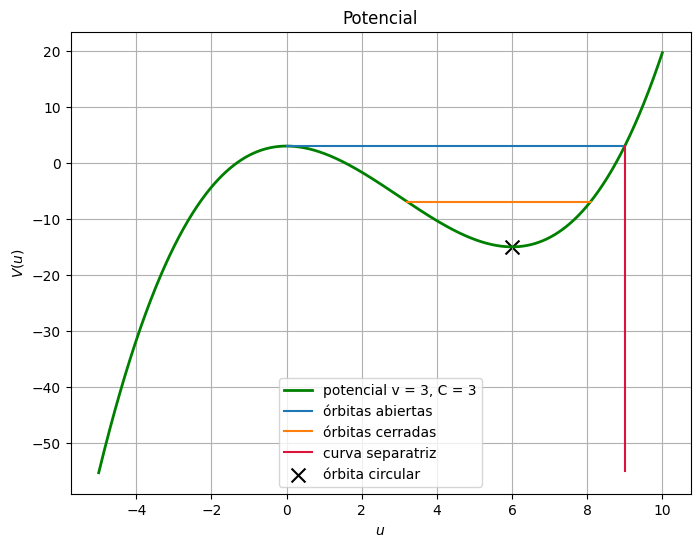

In [ ]:
def potential1(u, v, C):
    return (u**3)/6 - v*(u**2)/2 + C

u_values = np.linspace(-5, 10, 1000)

v = 3
C = 3

potential_values = potential1(u_values, v, C)

plt.figure(figsize=(8, 6))
plt.plot(u_values, potential_values, label='potencial' f' v = {v}, C = {C}', color = 'green', linewidth=2)
plt.plot(np.linspace(0, 9, 1000), np.linspace(3, 3, 1000), label='órbitas abiertas')
plt.plot(np.linspace(3.2, 8.1, 1000), np.linspace(-7, -7, 1000), label='órbitas cerradas')
plt.plot(np.linspace(3*v, 3*v, 1000), np.linspace(-55, 3, 1000), label='curva separatriz', color='crimson')
plt.scatter(2*v, -15, s=100, marker = 'x', color='black', alpha = 1, label = 'órbita circular')
plt.xlabel('$u$')
plt.ylabel('$V(u)$')
plt.title('Potencial')
plt.legend()
plt.grid(True)
plt.show()

En analogía al potencial newtoniano, identificamos las regiones de este potencial central de acuerdo a lo siguiente:

$\bf \cdot)$ Por encima de la recta azul, y mas allá de la curva separatriz, tendremos *órbitas abiertas*. Las soluciones con sentido físico se encuentran delimitadas por la curva separatriz, ya que las órbitas abiertas implican energía infinita.

$\bf \cdot)$ La recta naranja, que vive en el espacio definido por la recta azul y el pozo, marca la existencia de *órbitas cerradas elípticas*, las cuales son órbitas periódicas en $y = x-vt$, y, por lo tanto, marcan la aparición de **trenes de solitones**.

$\bf \cdot)$ La cruz negra marca un mínimo de potencial local, el cual podemos pensar que induce una *órbita circular*.

En la curva separatriz, se da que $u(\pm \infty) = 0$, lo cual define un **único solitón**.  

In [ ]:
#Inciso d

def evol(u, k, beta, N, dt):
    # Evoluciona en el tiempo la PDE usando el método pseudoespectral y Runge-Kutta de segundo orden
    f  = np.fft.rfft(u)     #vaya al espacio de Fourier
    ft = f
    for ord in [2,1]:       # Bucle para el Runge-Kutta
        D   = dt/ord
        fux = compute_advection(f,k,N)
        f  = ft + D*(-fux - beta * (1j*k)**3 * f)     # escriba aquí su integrador temporal
        f[int(N/3):] = 0    # Dealiasing (eliminemos modos espúreos!)
    out = np.fft.irfft(f)  # Vuelva del espacio de Fourier
    return out

def compute_advection(f,k,N):
    # Calcula v*vx (u\nabla)u usando el método pseudoespectral y devuelve el resultado en el espacio Fourier
    fx  = 1j*k*f                     #derivamos
    v   = np.fft.irfft(f)            # vuelva para poder multiplicar!
    vx  = np.fft.irfft(fx)           # eso de arriba
    v   = v*vx
    out = np.fft.rfft(v)
    return out

In [ ]:
#Continuación inciso d

def KdV(ti, tf, dt, N, beta, u_inic):

    x = np.linspace(0, 2*np.pi , N, endpoint = False) # Coordenada espacial en [0,2*pi)
    t = np.arange(ti, tf, dt)                     # Tiempo
    k = np.arange(0,N/2+1)
    v = - beta * k**2                     # Números de onda ordenados como en la FFT


    out = np.zeros((N,len(t)))
    out[:,0] = u_inic(x)
    for i in tqdm(np.arange(out.shape[1]-1)):           # Evolución temporal
        out[:,i+1] = evol(out[:,i],k,beta,N,dt)     #Completa para integrar (mira el bloque anterior)
    P = np.mean(out, axis=0)
    E = np.mean(out**2, axis=0)

    return out, P, E # velocidades[x,t], momento[t], energias[t]

In [ ]:
#Inciso e

u1, P1, E1 = KdV(0, 4, 1e-4, 162, 0.01, lambda x: np.cos(x - 1))
u2, P2, E2 = KdV(0, 4, 1e-4, 162, 0.01, lambda x: 3 * 1 * np.cosh(np.sqrt(1/(4 * 0.01)) * (x - 1))**(-2))
u3, P3, E3 = KdV(0, 4, 1e-4, 162, 0.01, lambda x: 3 * 1 * np.cosh(np.sqrt(1/(4 * 0.01)) * (x - 2))**(-2) + 3 * 2 * np.cosh(np.sqrt(2/(4 * 0.01)) * (x - 0.5))**(-2))

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

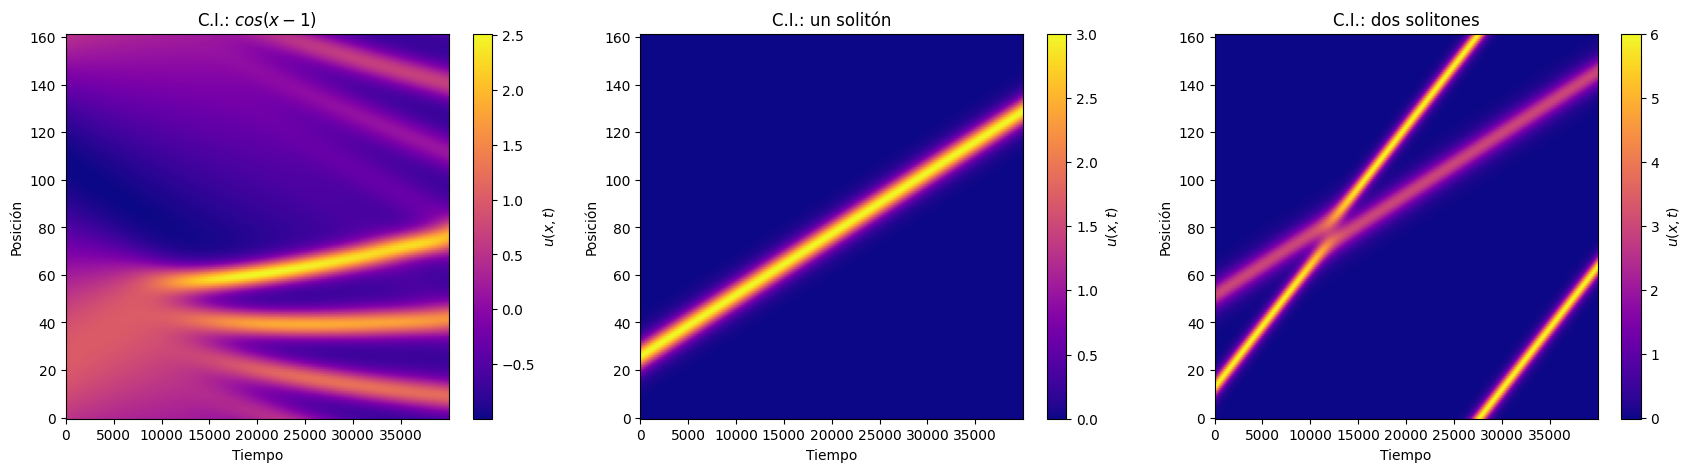

In [ ]:
#Continuación inciso e

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im1 = ax1.imshow(u1, origin='lower', aspect='auto', cmap='plasma')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Posición')
ax1.set_title('C.I.: $cos(x-1)$')
cbar1 = plt.colorbar(im1, ax=ax1, label='$u(x,t)$')

im2 = ax2.imshow(u2, origin='lower', aspect='auto', cmap='plasma')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Posición')
ax2.set_title('C.I.: un solitón')
cbar2 = plt.colorbar(im2, ax=ax2, label='$u(x,t)$')

im3 = ax3.imshow(u3, origin='lower', aspect='auto', cmap='plasma')
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Posición')
ax3.set_title('C.I.: dos solitones')
cbar3 = plt.colorbar(im3, ax=ax3, label='$u(x,t)$')

En los tres gráficos, se elige como parámetro $\beta = 1 \cdot 10^{-2}$. En el primer gráfico, hemos utilizado una condición inicial de coseno; vemos que a tiempos largos se empiezan a *emitir* solitones. Este comportamiento lo discutiremos en el último inciso. Para el segundo y el tercer gráfico, utilizamos condiciones iniciales de solitones.

$ \bf \cdot)$ En el segundo gráfico, se observa la evolución de un solo solitón que, como esperábamos, evoluciona sin deformarse.

$ \bf \cdot)$ En el tercer gráfico, se observa la evolución de dos solitones, uno rápido y uno lento. Nuevamente, los mismos se propagan sin deformarse; se aprecia que se afectan el uno al otro **solo** en el instante en el cual se intersecan, en el sentido en el cual la amplitud del solitón rápido resulta brevemente atenuada, pues ocurre una transferencia de momento entre los solitones. Un instante después, el solitón rápido *supera* al lento. Así, ambos continúan su evolución con el comportamiento típico de un solitón.

Más aún, mostramos a continuación animaciones a distintos tiempos para el segundo y el tercer gráfico, respectivamente, con la idea de confirmar estas conclusiones. Primero, la animación para el solitón único.

In [ ]:
#Continuación inciso e

x = np.linspace(0,2*np.pi,162,endpoint=False)

fig = plt.figure()

axis = plt.axes(title = 'Un solitón', xlabel = '$x$', ylabel = '$u$',
                xlim =(min(x)-0.1, max(x)+0.1), ylim =(min(map(min, u2))-0.1, max(map(max, u2))+0.1))
line, = axis.plot([], [], lw = 2, color = 'green', label = '$u(t)$')
plt.grid(True)
plt.legend(loc = 'upper right')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0,2*np.pi,162,endpoint=False)
    y = u2[:, i*200]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 150, interval = 50, blit = True, repeat = False)

plt.close()

In [ ]:
HTML(anim.to_html5_video())

En el video, efectivamente, se confirma nuestra observación: la onda viaja sin deformarse. A continuación, veamos una animación de los **dos solitones**.

In [ ]:
x = np.linspace(0,2*np.pi,162,endpoint=False)

fig = plt.figure()

axis = plt.axes(title = 'Dos solitones', xlabel = '$x$', ylabel = '$u$',
                xlim =(min(x)-0.1, max(x)+0.1), ylim =(min(map(min, u3))-0.1, max(map(max, u3))+0.1))
line, = axis.plot([], [], lw = 2, color = 'green', label = '$u(t)$')
plt.grid(True)
plt.legend(loc = 'upper right')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0,2*np.pi,162,endpoint=False)
    y = u3[:, i*160]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 150, interval = 60, blit = True, repeat = False)

plt.close()

In [ ]:
HTML(anim.to_html5_video())

Al igual que en el video anterior, se confirman nuestras observaciones: los dos solitones viajan sin deformase. Al chocar entre sí, interactúan de manera tal que el solitón rápido ve afectada brevemente su amplitud, aunque ninguno de los dos se deforma: el solitón rápido *supera* al lento, y ambos continúan evolucionando sin deformarse y con la misma amplitud que tenían antes de cruzarse.

In [ ]:
#Incisio f

def potential2(x, beta):
    return -np.sin(x)/(6*beta)

u_values = np.linspace(0, 10*np.pi, 128, endpoint = False)
beta = 0.022

potential_values2 = potential2(u_values, beta)

In [ ]:
u4, P4, E4 = KdV(0, 100, 5e-5, 128, 0.022, lambda x: np.sin(x))

  0%|          | 0/1999999 [00:00<?, ?it/s]

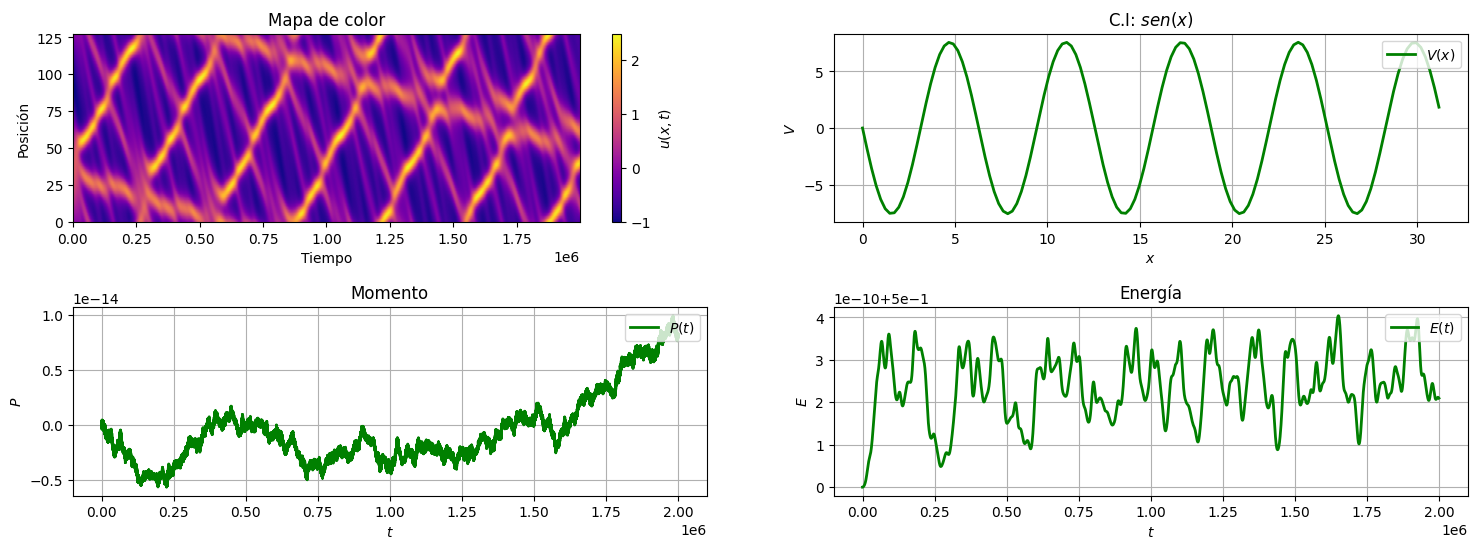

In [ ]:
#Continuación inciso f

fig, ((ax4, ax5), (ax6, ax7))= plt.subplots(2, 2, figsize = (18, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.45)

im4 = ax4.imshow(u4, origin='lower', aspect='auto', cmap='plasma')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Posición')
ax4.set_title('Mapa de color')
cbar4 = plt.colorbar(im4, ax=ax4, label='$u(x,t)$')

ax5.plot(u_values, potential_values2, label = '$V(x)$', color='green', linestyle='-', linewidth=2)
ax5.grid(True)
ax5.set_title('C.I: $sen(x)$')
ax5.set_ylabel('$V$')
ax5.set_xlabel('$x$')
ax5.legend(loc='upper right')

ax6.plot(P4, label = '$P(t)$', color='green', linestyle='-', linewidth=2)
ax6.grid(True)
ax6.set_title('Momento')
ax6.set_ylabel('$P$')
ax6.set_xlabel('$t$')
ax6.legend(loc='upper right')

ax7.plot(E4, label = '$E(t)$', color='green', linestyle='-', linewidth=2)
ax7.grid(True)
ax7.set_title('Energía')
ax7.set_ylabel('$E$')
ax7.set_xlabel('$t$')
ax7.legend(loc='upper right')

La zonas donde hay probabilidad de que se emita un solitón es en los pozos de potencial. Dada nuestra condicion inicial $\sin(x)$, notamos que, efectivamente, en el mapa de color aparecen solitones de forma periódica, en la medida que se alcanzan pozos de potencial. A su vez se aprecia, numéricamente, la conservación de la magnitudes presentadas en el primer inciso. A continuación, mostramos una animación de esta generación de solitones.

In [ ]:
x = np.linspace(0,2*np.pi,128,endpoint=False)

fig = plt.figure()

axis = plt.axes(title = 'C.I.: $sen(x)$', xlabel = '$x$', ylabel = '$u$',
                xlim =(min(x)-0.1, max(x)+0.1), ylim =(min(map(min, u4))-0.1, max(map(max, u4))+0.1))
line, = axis.plot([], [], lw = 2, color = 'green', label = '$u(t)$')
plt.grid(True)
plt.legend(loc = 'upper right')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0,2*np.pi,128,endpoint=False)
    y = u4[:, i*950]
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 250, interval = 50, blit = True, repeat = False)

plt.close()

In [ ]:
HTML(anim.to_html5_video())

Aquí observamos claramente la evolución del sistema a partir de la condición inicial especificada.